# Constructing dynamic film-maker collaboration networks and calculating brokerage social capital using IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

This notebook is part of a research project exploring the potential of social networks in promoting career longevity of women in leadership. Specifically, I explore whether connections with network brokers foster longer and more prolific careers for women movie directors, and how this effect differs from their men counterparts.

In the first phase, we mapped the career paths of directors who debuted between 2003 and 2013, tracing their filmography up to 2023. Now, let's move to the next phase: constructing the dynamic collaboration network among film-makers and calculate brokerage social capital of everyone in this network, for each year between 2000 and 2023.

Our Approach:

*1. Who are we including in the network?* 

We focus on creative workers in the movie industry: producers, directors, writers, editors, cinematographers, production designers, and composers. These are people responsible for the creative aspects of a movie.

*2. How do we define a connection?* 

We use a three-year moving window. This means if two film-makers worked together anytime in the past three years, they're connected in our network.

*3. How do we map a network that is ever changing?* 

Networks change all the time, some people enter the industry, some people leave it. To capture this dynamic nature of networks, we use 21 graphs, each capturing three years of collaborations from 2000 to 2023. We start in 2003, using collaboration data from 2000 to 2002 to construct our first window, and move forward to 2023, adding new entrants with each passing year. 

*4. How do we measure brokerage social capital:* 

To calculating film-makers' brokerage social capital, we use four metrics: constraint, effective size, betweenness centrality, and local clustering. These metrics will give each individual a yearly score reflecting their brokerage from 2003 to 2023.

By the end of this notebook, we'll have the brokerage scores of the collaborators of our movie directors. We can use them to analyze the impact of having ties with network brokers (those with high levels of brokerage social capital) on the career longevity of women and men directors. For this analysis, we'll also need to know the gender of the directors. Thus, in the next notebook, we'll be predicting the gender of directors using their first names from IMDb data and the US Social Security application data.

# Identifying creative workers in the film industry (2000-2023)

In this section, we focus on identifying the key creative personnel of the movies released from 2000 to 2023. These individuals represent the nodes in our collaboration networks. 

First, we set up our working environment by importing essential libraries and setting the working directory. We then load the dataset of movies released between 2000 and 2023 created in the previous notebook. Let's take a peek into this data:

In [2]:
# imports libraries
import pandas as pd
import os
import itertools
import networkx as nx
import random
from collections import deque
import multiprocessing as mp
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Set the working directory to where the project files are stored
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [15]:
# Load the dataset containing movies released from 2000 to 2023
movies_2000_2023 = pd.read_csv('movies_2000_2023.csv')

# Display the first few rows of the movies dataset
movies_2000_2023.head()

,tconst,startYear,genres
0,tt0011801,2019.0,"Action,Crime"
1,tt0013274,2021.0,Documentary
2,tt0015414,2000.0,\N
3,tt0028248,2022.0,Musical
4,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In this dataset, each row represents a movie released between 2000 and 2023, with columns for the release year (`startYear`) and genres (`genres`). 

To obtain information about the people behind these movies, we incorporate data from IMDb's `title.principals.tsv.gz`. This dataset contains information about key personnel in movie productions. Since our focus is on creative workers, we filter the principals dataset to include only the following roles: directors, producers, writers, editors, cinematographers, production designers, and composers.

Finally, we merge the principals data with our movies dataset. This creates in a dataset that links movie to their creative personnel, along with their corresponding release years. 

In [4]:
# Load the IMDb dataset containing information about key personnel (principals) in movie productions
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

# Filter the principals dataset to include only those in creative roles
creative_roles = ['director', 'producer', 'writer', 'editor', 'cinematographer', 'production_designer', 'composer']
df_principals = df_principals[df_principals['category'].isin(creative_roles)]

# Merge the movies dataset with the filtered principals dataset
# This creates a dataset linking movies released between 2000 and 2023 with the creative personnel involved
movies_collaborations_2000_2023 = df_principals[['tconst', 'nconst', 'category']].merge(movies_2000_2023[['tconst', 'startYear']], on='tconst', how='inner')

# Save the merged dataset to a CSV file
movies_collaborations_2000_2023.to_csv('movies_collaborations_2000_2023.csv' , index=False)

In [6]:
# Display the first few rows of the dataset
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


This data represents a bipartite network (or a two-mode network), with each row signifying a link between a creative worker (`nconst`)and a movie (`tconst`), indicating their involvement in that particular movie. Let's see how many people and movies there are in the data. 

In [7]:
# count the number of unique movies and creative workers
movies_collaborations_2000_2023.nunique()

tconst       296524
nconst       571851
category          7
startYear        24
dtype: int64

Our network comprise 571,851 creative workers who worked on 296,524 movies. Let's count the number of movies and creative personnel, as well as the average size of the creative team per movie for each year. This gives us a sense of the industry's scope and the scale of collaboration.

In [18]:
# Group the dataset by 'startYear' and count the unique number of movies and people (creative personnel) by year
count_movies_people = movies_collaborations_2000_2023.groupby('startYear').agg(
    num_movies=('tconst', pd.Series.nunique),
    num_creative_workers=('nconst', pd.Series.nunique)
)

# Calculate the average team size by year
# Group by release year and movie id to count the unique number of people involved in each movie
creative_team_size = movies_collaborations_2000_2023.groupby(['startYear', 'tconst']).nconst.nunique()
# Group by release year again and calculate the average size of these teams for each year
average_creative_team_size = creative_team_size.groupby('startYear').mean().rename('average_creative_team_size')

# Merge the counts and average team size into a single dataframe for analysis
summary_df = pd.merge(count_movies_people, average_creative_team_size, on='startYear').reset_index()

In [19]:
# display the dataframe with the movies and people count and average team size
summary_df

,startYear,num_movies,num_creative_workers,average_creative_team_size
0,2000.0,4919,17914,4.313275
1,2001.0,5337,19201,4.266254
2,2002.0,5496,20038,4.269651
3,2003.0,5698,21288,4.316076
4,2004.0,6321,23662,4.325107
5,2005.0,7225,26717,4.261730
6,2006.0,7859,29483,4.300674
7,2007.0,8461,31641,4.252807
8,2008.0,9879,36051,4.172183
9,2009.0,11330,40796,4.101236


Let's create bar charts to visualize trends in the number of movies, the number of people involved, and the average team size across the years.

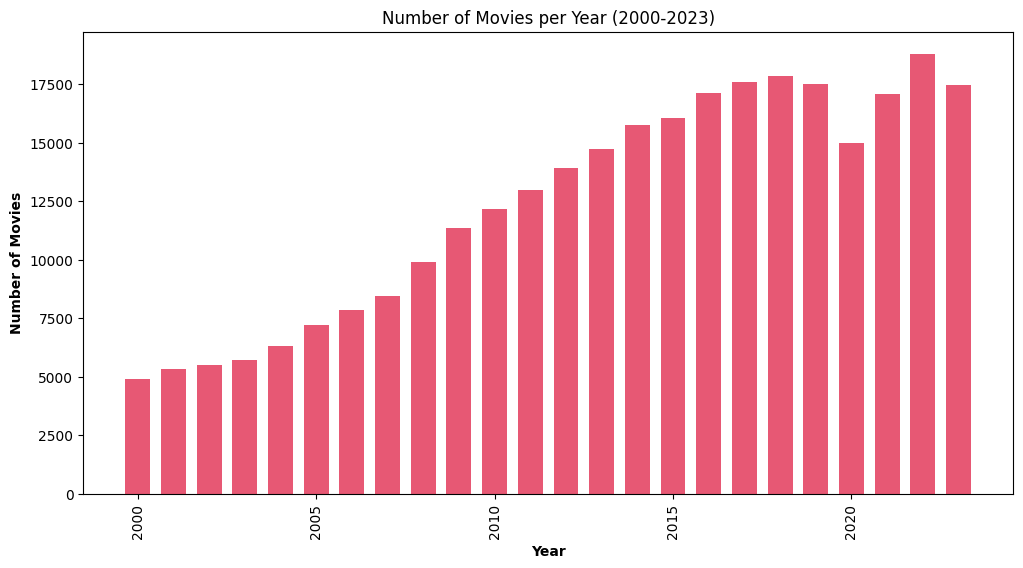

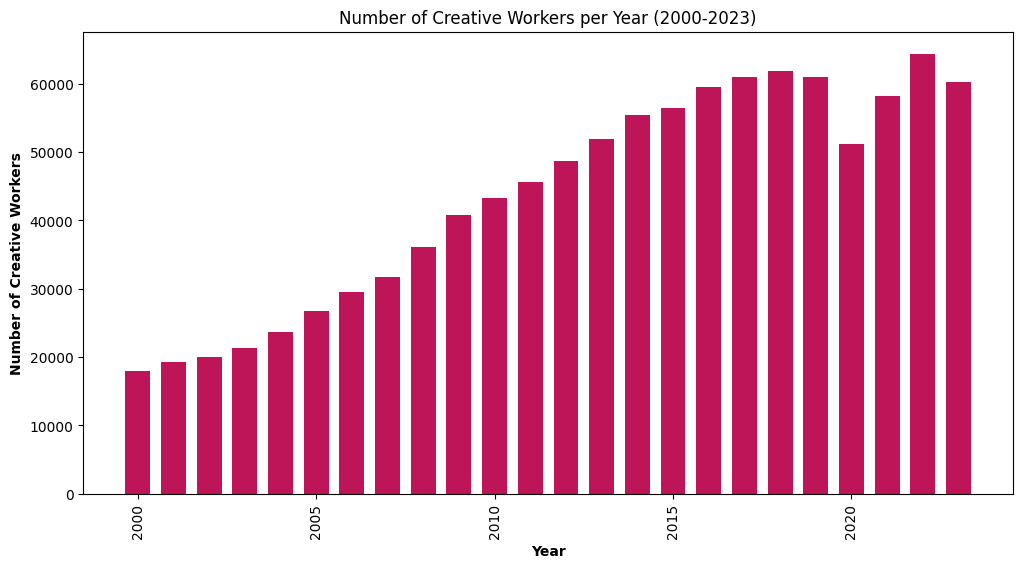

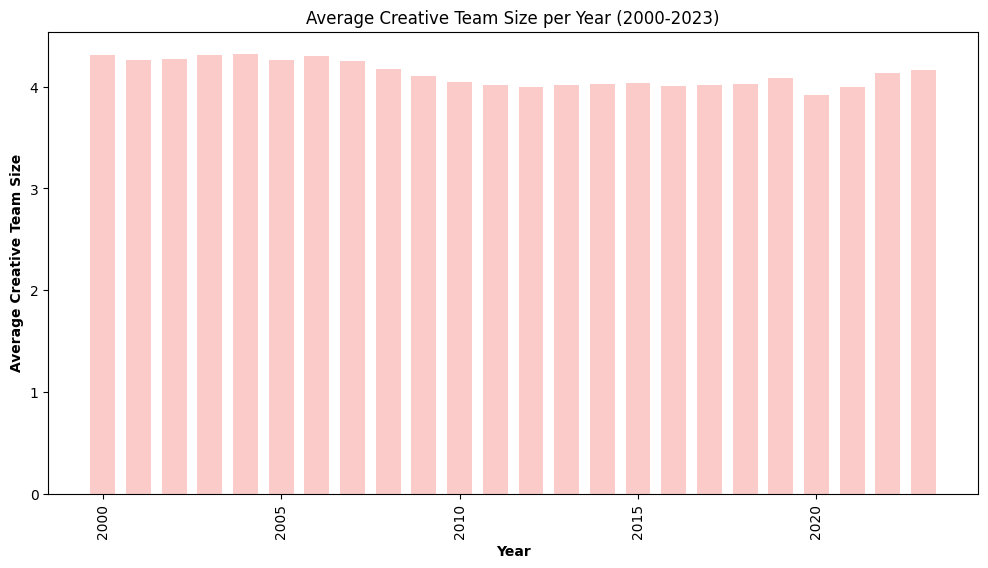

In [21]:
# Visualize the number of movies per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_movies'], color='#e75874', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Movies', fontweight='bold')
plt.title('Number of Movies per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

# Visualize the number of people (creative personnel) per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['num_creative_workers'], color='#be1558', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of Creative Workers', fontweight='bold')
plt.title('Number of Creative Workers per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

# Visualize the average team size per year using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(summary_df['startYear'], summary_df['average_creative_team_size'], color='#fbcbc9', width=0.7)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Creative Team Size', fontweight='bold')
plt.title('Average Creative Team Size per Year (2000-2023)')
plt.xticks(rotation=90)
plt.show()

Looks like the number of movies and the number of creative workers working on those movies increased a lot from 2000 to 2023. There is a noticeable dip in 2020, likely due to the Covid-19 pandemic, but a quick rebound by 2022. The average size of the creative team doesn't seem to change much over time. 

Since we are using a 3-year moving window to calculate brokerage social capital (meaning that a film-maker's brokerage social capital in a given year is based on their collaborations with other film-makers over a three-year period prior to the focal year), it's important to understand the network's evolution over these windows. Thus, let's count the number of movies and people in each of the 21 three-year moving windows. 

To do this, we first define each window to span three years, starting from 2000-2002 and moving annually up to 2020-2022. Then, we iterate through each window and count the unique movies and people involved. This provides us with a snapshot of the industry's creative network for that period.

In [11]:
# Initialize a list to store counts for each 3-year moving window
window_counts = []

# Loop through each year to calculate the counts for each 3-year moving window
for year in range(2003, 2024):  # From 2003 to 2023
    start_year = year - 3  # Start of the 3-year window
    end_year = year - 1    # End of the 3-year window

    # Filter the data for the current window
    window_data = movies_collaborations_2000_2023[
        movies_collaborations_2000_2023['startYear'].between(start_year, end_year)
    ]

    # Count the unique number of movies and people in the window
    num_movies = window_data['tconst'].nunique()
    num_people = window_data['nconst'].nunique()

    # Append the counts to the list
    window_counts.append({
        'Window Start': start_year,
        'Window End': end_year,
        'Number of Movies': num_movies,
        'Number of People': num_people
    })

# Convert the list of counts into a DataFrame
window_counts_df = pd.DataFrame(window_counts)
print(window_counts_df)

    Window Start  Window End  Number of Movies  Number of People
0           2000        2002             15752             47308
1           2001        2003             16531             50348
2           2002        2004             17515             54554
3           2003        2005             19244             60562
4           2004        2006             21405             67372
5           2005        2007             23545             73952
6           2006        2008             26199             81723
7           2007        2009             29670             91552
8           2008        2010             33376            101591
9           2009        2011             36485            109737
10          2010        2012             39071            116681
11          2011        2013             41626            124148
12          2012        2014             44373            132428
13          2013        2015             46507            139007
14          2014        2

Looks like our smallest network is the 2000-2002 window (comprising 47,308 creative workers) and the largest is the 2017-2019 window (comprising 154,952 creative workers). Let's also graph these counts to visualize the size of the creative network across different time periods.

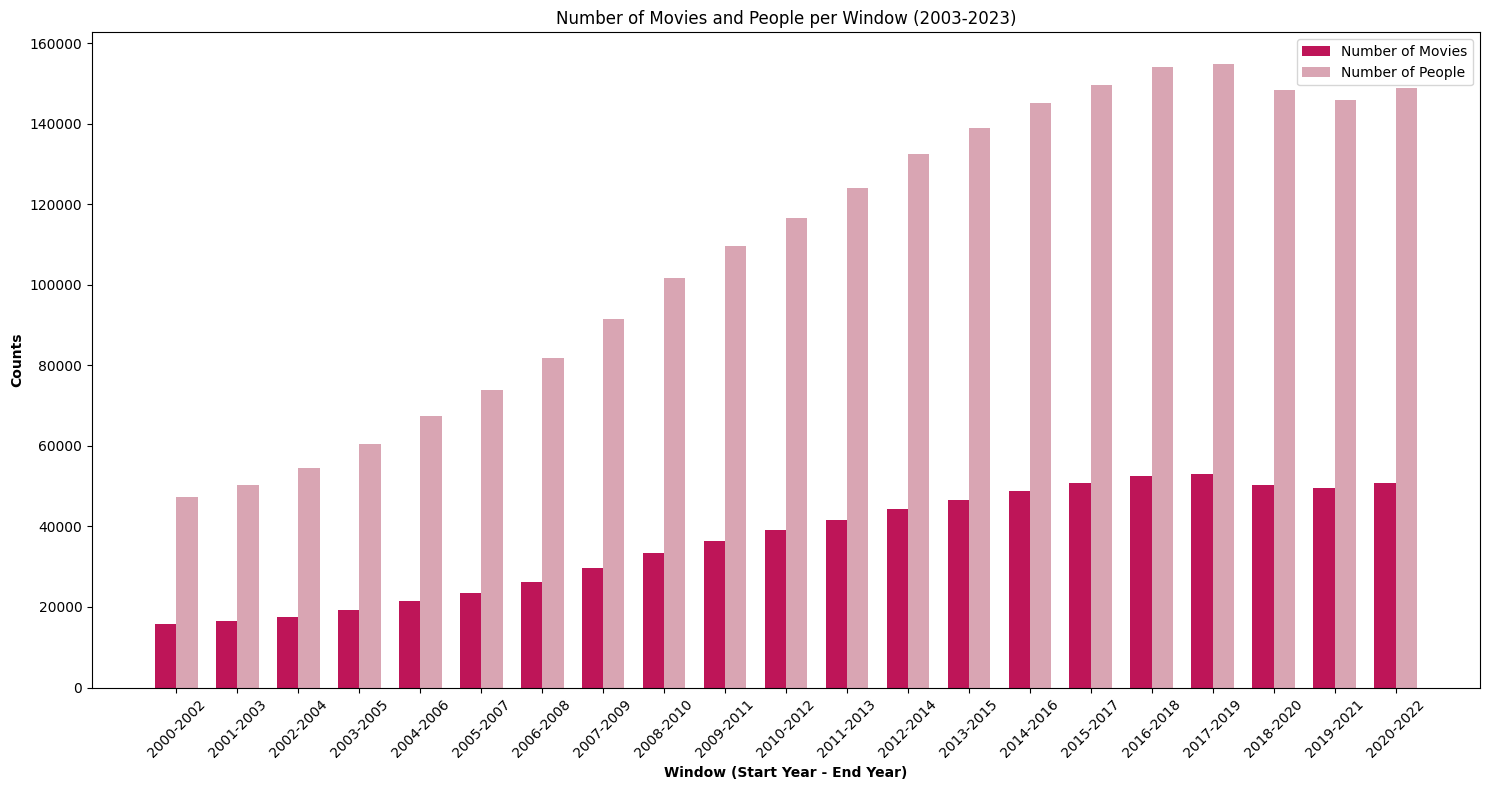

In [14]:
# Visualize the number of movies and people in each 3-year moving window using a bar chart
# Set the width of the bars
bar_width = 0.35

# Set positions of the bars
r1 = np.arange(len(window_counts_df))
r2 = [x + bar_width for x in r1]

# Create the bars
plt.figure(figsize=(15, 8))
plt.bar(r1, window_counts_df['Number of Movies'], color='#be1558', width=bar_width, label='Number of Movies')
plt.bar(r2, window_counts_df['Number of People'], color='#d9a5b3', width=bar_width, label='Number of People')

# Add xticks on the middle of the bar groups
plt.xlabel('Window (Start Year - End Year)', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(window_counts_df))], 
           [f"{row['Window Start']}-{row['Window End']}" for _, row in window_counts_df.iterrows()], rotation=45)

# Create legend & Show graphic
plt.legend()
plt.title('Number of Movies and People per Window (2003-2023)')
plt.tight_layout()
plt.show()


# Constructing dynamic collaboration network and calculating brokerage social capital 

In this section, we focus on constructing the dynamic collaboration networks in the film industry and calculating brokerage social capital for everyone in the network. This helps us obtain the brokerage scores of the directors's collaborators, which will then be used to predict their career longevity.

## The concept of a three-year moving window

As mentioned before, we use a 3-year moving window, where we calculate a person's brokerage social capital in a given year by looking at that person's collaborations with others in the three years before. 

For example, to calculate a person's brokerage social capital in the year 2003, we consider the collaborative ties they formed during 2000 to 2002. Then, to calculate that person's brokerage social capital in the year 2004, we consider the collaborative ties they formed during 2001 to 2003. Think of the period 2001-2003 as the time required for establishing the social capital that a person's bring to the year 2004. 

This process is repeated for each year up to 2023, shifting the window forward by one year at a time. This helps us capture the evolving nature of the collaboration network, with some connections fading while new ones emerge.

## From bipartite network to edge list

We start with the `movies_collaborations_2000_2023` dataset, representing a movie-people bipartite network. Our goal is to transform this data into a series of edge lists for each year within the 2000-2023 period. Each edge in these lists represents a collaboration between two creative workers in a given year. Then, we combine three edge lists together to form a rolling window and use NetworkX to construct a graph object to which we can apply various techniques to measure brokerage scores of each person in the network. 

## Functions for calculating brokerage social capital

We need to do these procedures 21 times to calculate social capital for every creative workers in the network for each year between 2003 and 2023. To automate this process, we create a function named `calculate_social_capital`. This function iterates over each year between 2003 and 2023. For each year, the function combines the edge lists denoting the collaborations (edges) from the previous three years, constructs a network graph from these edges, and calculates the following metrics:
- Constraint: Measures the extent to which a person's connections are also connected to one another.
- Effective Size: Measures the number of non-redundant contacts in a person's network.
- Betweenness Centrality: Measures the extent to which a person lies on the shortest path between others in the whole network.
- Local Clustering: Measures how closely a person's contacts are clustered together.


In [3]:
# Define a function to calculate various brokerage social capital metrics for a specified year and set of edges
# This function is placed in a separate Python script named "network_analysis_function.py" for parallel processing
def calculate_social_capital(year, edges_by_year):
    
    # Initialize a rolling window to accumulate edges over a 3-year period
    rolling_edges = deque()

    # For each year in the 3-year window leading up to the focal year, add the edges to the rolling window
    for y in range(year - 3, year):
        edges = edges_by_year.get(y, []) # Retrieve edges for the year 'y', defaulting to an empty list if not found
        rolling_edges.extend(edges) # Add these edges to the rolling window
    
    # Create a graph (network) using the edges accumulated in the rolling window
    G = nx.Graph()
    G.add_edges_from(rolling_edges) # Add the edges to the graph
    
    # Calculate brokerage scores for the nodes
    brokerage_scores = {
        # Constraint measures the extent to which a node's connections are to others that are connected to each other
        'constraint': nx.constraint(G), 
        # Effective size is a measure of the number of non-redundant contacts a node has
        'effective_size': nx.effective_size(G), 
        # Betweenness centrality measures the extent to which a node lies on shortest paths between other nodes
        'betweenness_centrality': nx.betweenness_centrality(G), 
        # Local clustering coefficient measures the degree to which nodes in a graph tend to cluster together
        'local_clustering': nx.clustering(G) 
    }
    return year, brokerage_scores

## Addressing the scale of data with parallel processing

Given the large scale of our 21 networks (with the largest network including over 150,000 people and the smallest still including over 47,000 people), we utilize parallel processing to speed up brokerage scores computations. Here, the task of network construction and social capital calculation is split across across multiple processes. 

Since our analysis involves some complex calculations, they aren't easily handled by the parallel processing method. Thus, we need a wrapper function, `calculate_social_capital_wrapper`, to simplify the process of invoking the main function across multiple processes. 

In our study, we analyze 21 large-scale networks, with the biggest encompassing over 150,000 individuals and even the smallest including more than 47,000. To efficiently manage this vast amount of data, we use parallel processing. This approach is similar to an assembly line in a factory, where the task of building each network and computing social capital metrics is distributed across multiple workers or processes. This can significantly speed up the overall computation time.

However, the complexity of our calculations presents a challenge to this method. To address this, we use a wrapper function named `calculate_social_capital_wrapper`. Think of this function as a concise guide that directs these processes/workers on how to efficiently carry out the detailed, complex instructions for our calculations in the `calculate_social_capital` function. This wrapper function simplifies the interaction between our computational processes and the intricate calculations they need to perform.

In [ ]:
# Wrapper function for parallel processing
# This function is placed in a separate Python script named "parallel_functions.py" for parallel processing
def calculate_social_capital_wrapper(year, edges_by_year):
    # Call the main function to calculate social capital metrics for a given year and its edges
    return calculate_social_capital(year, edges_by_year)

Now, there's another twist: we're doing all this in a Jupyter Notebook. While these digital notebooks are great for interactive analyses, they are not really suited for the kind of parallel processing we need. Specifically, parallel processing in Jupyter Notebooks can run into difficulties if all the necessary functions are defined directly within the notebook. To avoid this, we place our main calculation function `calculate_social_capital` and its wrapper function `calculate_social_capital_wrapper` in separate Python scripts (`network_analysis_function.py` and `parallel_functions.py`). This separation ensures that each process/worker in our computational assembly line can independently access and execute these functions without any hiccups. 

## Simulating a small-scale network for testing

Before applying these functions to our large-scale real-world data, we should test them in a controlled, simpler environment. This is where our toy example comes in – a simulated, small-scale network that mimics real-world collaborations in the film industry. By testing our functions on this smaller dataset first, we make sure everything works as intended before we tackle the computational overhead of the full dataset.

Here are what we will do to simulate a small-scale network of collaborations:

1. **Setting the stage:**: We set up a scenario spanning from the year 2000 to 2006, with two movies produced per year. 

2. **Populating the network:** We create a list of fictional people, designated as 'person1', 'person2', and so on, up to 'person11'. Among them, 'person1', 'person2', and 'person3' are identified as key players who frequently appear in these movies.

3. **Generating collaborations:** For each movie in each year, we randomly select a number of people to be involved, ensuring a mix of general participants and at least one key player. This randomness introduces variability, making our toy network more realistic.

4. **Forming connections:** We then create pairs from these selected individuals to represent collaborative ties, like how people in the film industry might work together on various projects.

5. **Restructuring the simulated data:** To make the toy data have similar structure to our actual dataset (the `movies_collaborations_2000_2023` data), we convert the simulated collaboration data into a DataFrame and restructure this data so that each row a link between a person (`nconst`)and a movie (`tconst`) along with the movie release year (`startYear`).


In [4]:
# Create a toy example to test and validate the function before applying it to the real dataset

# Settings for the toy example
years = range(2000, 2006) # Define the range of years
movies_per_year = 2 # Define the number of movies per year
people = ['person' + str(i) for i in range(1, 12)]  # Create a list of people identifiers
key_players = ['person1', 'person2', 'person3']  # Define key players who appear more frequently

# Generate random collaborations
data = []
for year in years:
    for movie_number in range(1, movies_per_year + 1):
        movie_id = f"movie_{year}_{movie_number}" # Construct a movie identifier
        num_people = random.randint(4, 9)  # Choose a random number of people for variability
        selected_people = random.sample(people, num_people) # Randomly select people to be involved in the movie
        selected_people.extend(random.sample(key_players, 1))  # Ensure inclusion of at least one key player
        selected_people = list(set(selected_people))  # Remove any duplicate people
        # Create pairs of people to represent collaborations
        for collaboration in itertools.combinations(selected_people, 2):
            data.append({'tconst': movie_id, 'startYear': year, 'nconst1': collaboration[0], 'nconst2': collaboration[1]})

# Convert the toy data into a DataFrame
toy = pd.DataFrame(data)

# Reshape the DataFrame to have all pairs in a single column
pairs_data = []
for _, row in toy.iterrows():
    pairs_data.append([row['tconst'], row['startYear'], row['nconst1']])
    pairs_data.append([row['tconst'], row['startYear'], row['nconst2']])

# Reformat the toy data into the final structure
toy = pd.DataFrame(pairs_data, columns=['tconst', 'startYear', 'nconst'])


Let's see what our toy data looks like:

In [5]:
toy

,tconst,startYear,nconst
0,movie_2000_1,2000,person2
1,movie_2000_1,2000,person4
2,movie_2000_1,2000,person2
3,movie_2000_1,2000,person3
4,movie_2000_1,2000,person2
...,...,...,...
461,movie_2005_2,2005,person9
462,movie_2005_2,2005,person1
463,movie_2005_2,2005,person8
464,movie_2005_2,2005,person9


Looks good! With this simulated small-scale network in hand, let's test our functions for calculating yearly brokerage social capital. 

## Testing the Toy Example with Parallel Processing

1. **Importing the function to calculate brokerage**: We start by importing the `calculate_social_capital_wrapper` function, a function we specifically created to serve as a simplified intermediary, facilitating the use of our main function, `calculate_social_capital`, in a parallel processing setup. It's designed to manage the complex calculations of brokerage social capital across multiple processors efficiently.

2. **Creating an edgelist for each year in the data**:
   - We define a function, `create_pairs`, to identify all pairs of collaborators (edges) within our toy data. Each pair/edge represents a connection between two people in the network. We then group the data by movie and year and apply `create_pairs` to each grouping. This creates list of collaboration pairs for each movie.
   - To optimize computational efficiency, we further organize these collaboration pairs by year. This produces a dictionary (`edges_by_year`), where each key corresponds to a year, and its value contains all collaboration edges for that year. This helps speed up up the calculation process, allowing us avoid repetitively traversing the entire dataset when analyzing the network of each year. 

3. **Setting up parallel processing**:
   - We set up a multiprocessing pool using `mp.Pool(mp.cpu_count())`, which allocates the task to multiple processors on the computer. This is similar to an assembly line, where different parts of the task are handled concurrently.
   - For our toy example, we focus on the years 2003 to 2006, a manageable range that allows us to test our methodology. 

4. **Performing the calculations**:
   - We use the `pool.starmap` method to apply `calculate_social_capital_wrapper` to each year in our test range, passing the edges of each year as input. This allows us to calculate brokerage scores for each year simultaneously.
   - Once the calculations for each year are complete, we close the pool and ensure all processes have concluded their tasks.

5. **Collecting and reviewing the Results**:
   - The results, which include the brokerage scores for each year of our toy example, are compiled into a dictionary, `brokerage_scores_by_year`.

In [6]:
# Process the toy example data to calculate brokerage scores using parallel processing

# Import the wrapper function for calculating brokerage social capital for parallel processing
from parallel_functions import calculate_social_capital_wrapper 

# Define a function to create pairs of collaborators from the toy data
def create_pairs(group):
    # For each group of data, create all possible pairs of collaborators
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

# Main execution block
if __name__ == "__main__":
    # Group the toy data by movie and year, and apply the pair creation function
    toy = toy.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year for the toy data
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in toy.groupby('startYear')}
    
    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process for the toy example
    years = range(2003, 2006)

    # Calculate brokerage scores for each year in parallel
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()
    
    # Collect the calculated brokerage scores by year
    brokerage_scores_by_year = {year: scores for year, scores in results}

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1247/74822363.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toy = toy.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)


Let's review these scores to see whether our functions are performing as expected.

In [7]:
brokerage_scores_by_year

{2003: {'constraint': {'person2': 0.3649243318664806,
   'person4': 0.3649243318664806,
   'person3': 0.3649243318664806,
   'person10': 0.3649243318664806,
   'person9': 0.3784793388429753,
   'person1': 0.3784793388429753,
   'person5': 0.3784793388429753,
   'person6': 0.3649243318664806,
   'person8': 0.3784793388429753,
   'person7': 0.4071994795556947,
   'person11': 0.3649243318664806},
  'effective_size': {'person2': -0.1999999999999993,
   'person4': -0.1999999999999993,
   'person3': -0.1999999999999993,
   'person10': -0.1999999999999993,
   'person9': -1.0,
   'person1': -1.0,
   'person5': -1.0,
   'person6': -0.1999999999999993,
   'person8': -1.0,
   'person7': -1.0,
   'person11': -0.1999999999999993},
  'betweenness_centrality': {'person2': 0.014814814814814815,
   'person4': 0.014814814814814815,
   'person3': 0.014814814814814815,
   'person10': 0.014814814814814815,
   'person9': 0.0,
   'person1': 0.0,
   'person5': 0.0,
   'person6': 0.014814814814814815,
   'pers

Everything looks good! Now, we can proceed to apply these functions to our actual dataset of movie collaborations.

## Applying the functions to the real dataset

We apply the same processes to our actual dataset of movie collaborations. This dataset contains information about individuals who have worked on movies released between 2000 and 2023. The goal is to utilize our parallel processing setup to calculate brokerage social capital metrics for each individual in the dataset, for each year from 2003 to 2023. The steps are as follows. 

1. **Loading the dataset:** We begin by loading the `movies_collaborations_2000_2023` dataset. 

2. **Preparing the data for network analysis:**
- Similar to our approach with the toy example, we define and apply the `create_pairs` function to the real dataset. This function identifies all possible collaborative pairs (edges) for each movie in the data.
- We then organize these pairs by year, resulting in a yearly mapping of collaboration edges (`edges_by_year`). 

3. **Executing parallel calculations:**
- Utilizing a multiprocessing pool `(mp.Pool(mp.cpu_count()))`, we distribute the task of calculating brokerage scores across multiple processors. 
- We focus on the years 2003 to 2023.

4. **Calculating brokerage scores:**
- We apply `calculate_social_capital_wrapper` to each year in our dataset, using the `pool.starmap` method. This calculates the brokerage scores concurrently for each year.
- Upon completing the calculations, we ensure the pool is closed, and all processes are finished.

5. **Storing the results for future analysis:**
- The results - the brokerage scores for each year - are compiled into a dictionary (`brokerage_scores_by_year`). We save this dictionary as a pickle file (`brokerage_scores_by_year.pkl`). This file will be instrumental in our future analysis, particularly in identifying the brokerage scores for the collaborators of the directors in our sample.



In [ ]:
# Apply the same process to the actual dataset of movie collaborations
# Load the real dataset containing movie collaborations from 2000 to 2023
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

from parallel_functions import calculate_social_capital_wrapper 

def create_pairs(group):
    return pd.DataFrame(itertools.combinations(group['nconst'], 2), columns=['person1', 'person2'])

if __name__ == "__main__":
    # Group the real dataset by movie and year, and create pairs of collaborators
    movies_collaborations_2000_2023 = movies_collaborations_2000_2023.groupby(['tconst', 'startYear']).apply(create_pairs).reset_index().drop('level_2', axis=1)
    # Organize the edges by year 
    edges_by_year = {year: group[['person1', 'person2']].values for year, group in movies_collaborations_2000_2023.groupby('startYear')}

    # Create a multiprocessing pool for parallel processing
    pool = mp.Pool(mp.cpu_count())
    # Define the years to process
    years = range(2003, 2023)
    
    # Calculate brokerage scores for each year in parallel 
    results = pool.starmap(calculate_social_capital_wrapper, [(year, edges_by_year) for year in years])
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Collect the calculated brokerage scores by year 
    brokerage_scores_by_year = {year: scores for year, scores in results}
    
    # Save the calculated brokerage scores as a pickle file for future use
    with open('brokerage_scores_by_year.pkl', 'wb') as f:
        pickle.dump(brokerage_scores_by_year, f)